<h3>Classify names in multiple languages using RNN</h3>
<p>The notebook includes the steps to build RNN from scratch in PyTorch. This network is then used to build a multi-classifier to identify the language of people's names. Steps to train and evaluate a model in the most basic way are also mentioned here.</p>

In [1]:
%%bash

# Download and unzip dataset
curl -o data.zip https://download.pytorch.org/tutorial/data.zip

data_dir="pytorch_rnn_classification"
rm -r $data_dir
unzip data.zip -d $data_dir
rm data.zip

Archive:  data.zip
   creating: pytorch_rnn_classification/data/
  inflating: pytorch_rnn_classification/data/eng-fra.txt  
   creating: pytorch_rnn_classification/data/names/
  inflating: pytorch_rnn_classification/data/names/Arabic.txt  
  inflating: pytorch_rnn_classification/data/names/Chinese.txt  
  inflating: pytorch_rnn_classification/data/names/Czech.txt  
  inflating: pytorch_rnn_classification/data/names/Dutch.txt  
  inflating: pytorch_rnn_classification/data/names/English.txt  
  inflating: pytorch_rnn_classification/data/names/French.txt  
  inflating: pytorch_rnn_classification/data/names/German.txt  
  inflating: pytorch_rnn_classification/data/names/Greek.txt  
  inflating: pytorch_rnn_classification/data/names/Irish.txt  
  inflating: pytorch_rnn_classification/data/names/Italian.txt  
  inflating: pytorch_rnn_classification/data/names/Japanese.txt  
  inflating: pytorch_rnn_classification/data/names/Korean.txt  
  inflating: pytorch_rnn_classification/data/names/Poli

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0   693k      0  0:00:04  0:00:04 --:--:--  693k


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [3]:
# Fetch files from dataset
data_path = "pytorch_rnn_classification/data/names/*.txt"
data_files = glob.glob(data_path)
print("Data files: {0}".format(data_files))

# Define input letters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("\nAll chars:", all_letters)

Data files: ['pytorch_rnn_classification/data/names/Czech.txt', 'pytorch_rnn_classification/data/names/German.txt', 'pytorch_rnn_classification/data/names/Arabic.txt', 'pytorch_rnn_classification/data/names/Japanese.txt', 'pytorch_rnn_classification/data/names/Chinese.txt', 'pytorch_rnn_classification/data/names/Vietnamese.txt', 'pytorch_rnn_classification/data/names/Russian.txt', 'pytorch_rnn_classification/data/names/French.txt', 'pytorch_rnn_classification/data/names/Irish.txt', 'pytorch_rnn_classification/data/names/English.txt', 'pytorch_rnn_classification/data/names/Spanish.txt', 'pytorch_rnn_classification/data/names/Greek.txt', 'pytorch_rnn_classification/data/names/Italian.txt', 'pytorch_rnn_classification/data/names/Portuguese.txt', 'pytorch_rnn_classification/data/names/Scottish.txt', 'pytorch_rnn_classification/data/names/Dutch.txt', 'pytorch_rnn_classification/data/names/Korean.txt', 'pytorch_rnn_classification/data/names/Polish.txt']

All chars: abcdefghijklmnopqrstuvwxyz

In [4]:
# Convert unicode char to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Read dataset and group into categories
for filename in data_files:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("All categories: ", all_categories)
print("\nEnglish words: ", category_lines["English"][:20])

All categories:  ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']

English words:  ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd', 'Acton', 'Adair', 'Adam', 'Adams', 'Adamson', 'Adanet', 'Addams', 'Adderley', 'Addinall', 'Addis']


In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Convert a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Convert a word to a tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print("Tensor of J: \n\t", letterToTensor('J'))
print("\nTensor of Jones has diamensions: ", lineToTensor('Jones').size())

Tensor of J: 
	 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

Tensor of Jones has diamensions:  torch.Size([5, 1, 57])


In [7]:
import torch.nn as nn

# Define a class for RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # Diamention of hidden state
        self.hidden_size = hidden_size

        # Hidden state and output are combination of previous hidden states and input
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Concatenate input and prev hidden state
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Initialize hidden state to zero
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
# Verify RNN layer output and prediction for a word
word = "Albert"
input = lineToTensor(word)

hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)

print("RNN output for {0}: \n\t{1}".format(word, output))

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

language, prediction = categoryFromOutput(output)
print("\nLanguage of {0}: {1}, predictions: {2}".format(word, language, prediction))

RNN output for Albert: 
	tensor([[-2.9736, -2.8509, -2.8175, -2.8053, -2.9175, -2.9236, -2.9090, -2.9480,
         -2.8130, -2.9144, -2.9351, -2.8920, -2.9864, -2.8756, -2.9089, -2.7680,
         -2.8357, -2.9888]], grad_fn=<LogSoftmaxBackward>)

Language of Albert: Dutch, predictions: 15


In [9]:
import random

# Get random sample from a list
def randomChoice(samples):
    return samples[random.randint(0, len(samples) - 1)]

# Fetch a random word for training
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)

    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Jirmunsky
category = Japanese / line = Tani
category = Arabic / line = Baba
category = Japanese / line = Koyanagi
category = German / line = Abbing
category = Korean / line = Gu
category = Portuguese / line = Gomes
category = Chinese / line = Huang
category = Irish / line = Bradan
category = French / line = Rome


In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005

# Define training with a word sample
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # Initialize gradients to zero
    rnn.zero_grad()

    # Iterate over the length of the word
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Evaluate loss and gradients
    loss = criterion(output, category_tensor)
    loss.backward()

    # Reduce parameter values proportional to gradients, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

# Define training loop
for iter in range(1, n_iters + 1):
    # Fetch random sample word and label
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.3781 Maessen / Irish ✗ (Dutch)
10000 10% (0m 15s) 2.0273 Uttley / English ✓
15000 15% (0m 22s) 1.9156 Koukal / Arabic ✗ (Czech)
20000 20% (0m 30s) 2.3291 Sarkozy / Irish ✗ (French)
25000 25% (0m 38s) 1.5511 Kikkert / Japanese ✗ (Dutch)
30000 30% (0m 45s) 1.9942 Hunter / German ✗ (Scottish)
35000 35% (0m 52s) 1.2724 Vlasak / Polish ✗ (Czech)
40000 40% (1m 0s) 3.7853 Rompay / English ✗ (Dutch)
45000 45% (1m 7s) 0.2812 Millar / Scottish ✓
50000 50% (1m 15s) 0.9046 Yu / Vietnamese ✗ (Korean)
55000 55% (1m 23s) 3.4006 Doljs / Greek ✗ (Czech)
60000 60% (1m 30s) 1.1996 Marion / French ✓
65000 65% (1m 38s) 2.2832 Redding / Chinese ✗ (English)
70000 70% (1m 46s) 0.4019 Davidson / Scottish ✓
75000 75% (1m 54s) 2.6281 Hayden / Dutch ✗ (Irish)
80000 80% (2m 2s) 1.9683 Clark / Irish ✗ (Scottish)
85000 85% (2m 10s) 1.7320 Matos / Greek ✗ (Portuguese)
90000 90% (2m 18s) 0.8164 Schoorl / Dutch ✓
95000 95% (2m 27s) 0.7911 Escarcega / Spanish ✓
100000 100% (2m 35s) 1.0207 Wallace / Eng

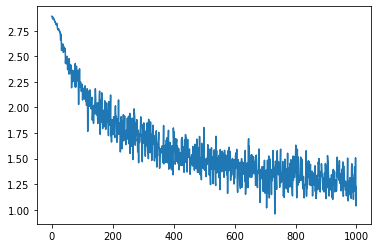

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot loss during the training
plt.figure()
plt.plot(all_losses)
plt.show()

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a word
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Define validation loop
for i in range(n_confusion):
    # Fetch random sample word and label
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

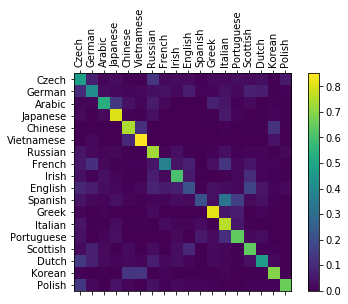

In [14]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
# Show top-n predictions for a word
def predict(input_line, n_predictions):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky', 3)
predict('Jackson', 3)
predict('Satoshi', 3)


> Dovesky
(-0.46) Czech
(-1.24) Russian
(-3.20) Polish

> Jackson
(-0.33) Scottish
(-2.12) Russian
(-2.47) English

> Satoshi
(-0.61) Japanese
(-1.26) Italian
(-2.99) Arabic
